航空公司客户价值分析
    目标：企业针对不同价值的客户制定个性化的服务，将有限的资源集中于高价值客户。
    1、借助航空公司的数据进行客户分类
    2、比较不同类客户的价值并制定销策略
    
识别客户价值的最广泛的模型是通过RFM模型来识别出高价值的客户：
    Recency： 最近消费时间间隔
    Frequency： 消费频率
    Monetary： 消费金额
问题：同样的消费金额的不同旅客对航空公司的价值不同，例如买长航线、低等仓的旅客和买短航线、高等仓的旅客消费金额相同
但是价值确实不同的。显然后者更有价值。因此这个指标可能不合适，故选择客户在一定时间内的飞行里程M和乘坐舱位所对应的折扣洗漱C。

航空公司客户价值分析模型：
    L：会员入会时间距观测窗口结束的时间
    R：客户最近一次乘坐公司分级距观测窗口结束的时间（月数）
    F：客户在观测窗口内乘坐公司飞机的次数
    M：客户在观测窗口内累计的飞行里程
    C：客户在观测窗口内乘坐舱位所对应的折扣系数的平均值
模型概述：
    通过使用k-means聚类算法没使用LRFMC模型进行测试
    对模型进行分析，分析客户的价值


In [1]:
import pandas as pd

In [8]:
datafile = 'data/air_data.csv'
resultfile = 'data/tmp.xls' 
data = pd.read_csv(datafile, encoding='utf-8')

explore = data.describe().T 
explore['null'] = len(data) - explore['count'] #计算空值


explore = explore[['null', 'max', 'min']]  #得到每一列的空值，最大值，最小值


explore.to_excel(resultfile) # 是结果写入文件


/home/xiaoran/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


根据上面的数据统计，丢弃所有不符合的数据，
    1、票价为空的
    2、票价为0，但是折扣不是0，而且飞行里程大于0，
    这样的数据是错误数据，直接删除。

In [27]:
data = pd.read_csv(datafile, encoding='utf-8')

cleanedfile = 'data/cleanfile.csv' #存清理后的数据

# 去掉票价是空的元素
data = data[data['SUM_YR_1'].notnull()]
data = data[data['SUM_YR_2'].notnull()]


# 去掉票价为0，但是折扣不是0，而且飞行里程大于0
data = data.drop(data['SUM_YR_1'] ==0 & (data['SEG_KM_SUM'] != 0) | (data['avg_discount'] > 0))

print(len(data))

# print(data.columns)

# 属性规约：去掉不相管的属性，只留下与LRFMC模型相关的属性
# FFP_DATE 入会时间
# LOAD_TIME 观测窗口结束时间
# FLIGHT_COUNT 飞行频率
# avg_discount 平均折扣
# SEG_KM_SUM 观测窗口总飞行公里数
# LAST_TO_END 最后一次乘机时间至观察窗口末端时长

data = data[['FFP_DATE','LOAD_TIME', 'FLIGHT_COUNT', 'avg_discount', 'SEG_KM_SUM','LAST_TO_END']]


data.to_csv(cleanedfile) #写入文件

62297
Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'EP_SUM_YR_1', 'EP_SUM_YR_2', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'WEIGHTED_SEG_KM', 'LAST_FLIGHT_DATE',
       'AVG_FLIGHT_COUNT', 'AVG_BP_SUM', 'BEGIN_TO_FIRST', 'LAST_TO_END',
       'AVG_INTERVAL', 'MAX_INTERVAL', 'ADD_POINTS_SUM_YR_1',
       'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount',
       'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BP_SUM', 'L1Y_BP_SUM',
       'EP_SUM', 'ADD_Point_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points',
       'Points_Sum', 'L1Y_Points_Sum', 'Ration_L1Y_Flight_Count',
       'Ration_P1Y_Flight_Count', 'Ration_P1Y_BPS', 'Ration_L1Y_BPS',
       'Point_NotFlight'],
      dtype='object')


数据变化的LRFMC数据：
    L = LOAD_TIME - FFP_DATE （观测窗口时间 - 入会时间）
    R = LOAD_TIME - LAST_TO_END （观测窗口时间 - 最后一次乘机时间）
    F = FLIGHT_COUNT 
    M = SEG_KM_SUM
    C = avg_discount


In [88]:
from datetime import datetime
import time

def normal_time(date):
    '''
    格式化数据
    '''
    return datetime.strptime(date,"%Y/%m/%d")

def interval_time(dd):
    '''
    计算时间间隔，以月为单位
    '''
    return dd.days / 30

In [105]:
# data_LRFMC数据
data_LRFMC = pd.DataFrame()
# data_LRFMC.columns = ['L', 'R', 'F','M', 'C']
data_LRFMC['L'] = (data['LOAD_TIME'].apply(normal_time) - data['FFP_DATE'].apply(normal_time)).apply(interval_time)
data_LRFMC['R'] = data['LAST_TO_END']
data_LRFMC['F'] = data['FLIGHT_COUNT']
data_LRFMC['M'] = data['SEG_KM_SUM']
data_LRFMC['C'] = data['avg_discount']

# 显示数据的描述，最大值和最小值
data_LRFMC_describe = data_LRFMC.describe().T
data_LRFMC_describe = data_LRFMC_describe[['max','min']].T

data_LRFMC.to_csv('data/LRFMC.csv') #数据写入文件

注意到所有的数据值，最大值和最小值间隔较大，需要对数据进行标准化
    这里使用标注差标准化,可以使用认识方法进行处理

In [114]:
# 标准化、重命名、写入文件
data_normal = (data_LRFMC - data_LRFMC.mean()) / (data_LRFMC.std())
data_normal.columns = ['Z'+i for i in data_normal.columns]
data_normal.to_csv('data/data_normal')


数据处理完毕，下面进行模型的构建，
    1、使用聚类算法，将数据生成5类用户
    2、针对聚类结果进行特征分析

In [117]:
from sklearn.cluster import KMeans
k = 5
kmodel = KMeans(k) #得到模型
kmodel.fit(data_normal) #训练模型

# 查看聚类中心和对应的类别
print(kmodel.cluster_centers_)
print(kmodel.labels_)


[[ 1.16443082 -0.3775831  -0.08518766 -0.09323092 -0.15906231]
 [-0.70014625 -0.41584827 -0.15935193 -0.15955595 -0.26734394]
 [ 0.01594116  0.00784598 -0.24843215 -0.25750534  2.08918975]
 [ 0.48503896 -0.80134848  2.48281809  2.43536635  0.31393202]
 [-0.31252471  1.68746582 -0.57426021 -0.53886494 -0.18594193]]
[3 3 3 ..., 1 0 4]


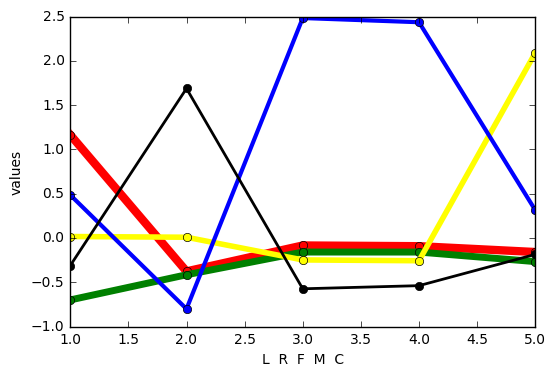

In [130]:
import matplotlib.pyplot as plt

clu = kmodel.cluster_centers_
x = [1,2,3,4,5]

colors = ['red','green','yellow','blue','black']
for i in range(5):
    plt.plot(x,clu[i],label='clustre '+str(i),linewidth=6-i,color=colors[i],marker='o') 

plt.xlabel('L  R  F  M  C')
plt.ylabel('values')
plt.show()


客户价值分析：
注意kmeans每次运行的时候得到的类会有差别，簇号也会相应的改变，但是中间点基本不会改变：
              L           R           F           M           C
客户群1：[ 1.16443082 -0.3775831  -0.08518766 -0.09323092 -0.15906231] red
客户群2：[-0.70014625 -0.41584827 -0.15935193 -0.15955595 -0.26734394] green
客户群3：[ 0.01594116  0.00784598 -0.24843215 -0.25750534  2.08918975] yellow
客户群4：[ 0.48503896 -0.80134848  2.48281809  2.43536635  0.31393202] blue
客户群5：[-0.31252471  1.68746582 -0.57426021 -0.53886494 -0.18594193] black

我们重点关注的是L，F，M，从图中可以看到：
1、客户群4[blue] 的F,M很高，L也不低，可以看做是重要保持的客户；
2、客户群3[yellow] 重要发展客户
3、客户群1[red] 重要挽留客户，原因：入会时间长，但是F,M较低
4、客户群2[green] 一般客户
5、客户群5[black] 低价值客户


